## Airbnb DC Hosting Helper ##

## 7_production_models ## 

### Summary ###

This notebook will be presenting the final production models (one for best prediction and one for best interpretation for recomendations) and their evaluation metrics. I will be exporting them to use in deployment as well. 

Import libraries.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay

In [16]:
np.random.seed(100)

In [17]:
pd.set_option('display.max_columns', 300)

In [18]:
pd.set_option('display.max_rows', 300)

Read in data and prepare for modeling by dropping unnecessary columns.

In [19]:
df = pd.read_csv('../data/final_df.csv')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 100 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Unnamed: 0                                3652 non-null   int64  
 1   id                                        3652 non-null   int64  
 2   name                                      3652 non-null   object 
 3   description                               3609 non-null   object 
 4   neighborhood_overview                     2794 non-null   object 
 5   host_id                                   3652 non-null   int64  
 6   host_about                                2529 non-null   object 
 7   host_response_time                        3652 non-null   object 
 8   host_response_rate                        3652 non-null   float64
 9   host_acceptance_rate                      3652 non-null   float64
 10  host_is_superhost                  

In [21]:
df.drop(columns = ['Unnamed: 0', 'id', 'host_id',  'amenities', 'latitude_x', 'longitude_x',
                   'name', 'description', 'neighborhood_overview', 'host_about'
                  ], inplace=True)

Make all columns in snake case below.

In [22]:
cols = df.columns

new_cols = []

for i in cols:
    new_cols.append(i.replace(' ','_'))

In [23]:
df.columns = new_cols

In [24]:
df.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,instant_bookable,calculated_host_listings_count,historic_site,museum,metro,music_venue,perfomring_arts_venue,college_and_university,food,nightlife_spot,outdoors_and_recreation,government_building,clothing_store,popular,days_being_host,days_since_first_review,days_since_last_review,name_word_count,name_neutral_sentiment,name_negative_sentiment,name_positive_sentiment,name_compound_sentiment,description_word_count,description_neutral_sentiment,description_negative_sentiment,description_positive_sentiment,description_compound_sentiment,neighborhood_overview_word_count,neighborhood_overview_neutral_sentiment,neighborhood_overview_negative_sentiment,neighborhood_overview_positive_sentiment,neighborhood_overview_compound_sentiment,host_about_word_count,host_about_neutral_sentiment,host_about_negative_sentiment,host_about_positive_sentiment,host_about_compound_sentiment,wifi,smoke_alarm,essentials,heating,air_conditioning,hangers,iron,kitchen,long_term_stays_allowed,hair_dryer,carbon_monoxide_alarm,hot_water,shampoo,dedicated_workspace,dishes_and_silverware,microwave,washer,dryer,fire_extinguisher,refrigerator,coffee_maker,cooking_basics,private_entrance,bed_linens,stove,oven,free_street_parking,dishwasher,first_aid_kit,extra_pillows_and_blankets,tv,patio_or_balcony
0,within a day,0.8,0.75,0,1,1,Historic Anacostia,Private room,1,1.0,1.0,1.0,55.0,2,365,2.0,365.0,1,31,61,336,0,2,1,2,1,0,3,10,25,5,28,21,5,0,4610,2576,180,3,1.000,0.0,0.000,0.0000,164,0.867,0.016,0.117,0.9230,25,0.846,0.000,0.154,0.6369,180,0.818,0.000,0.182,0.9828,1,1,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,0,1
1,within an hour,1.0,0.93,0,1,1,"Spring Valley, Palisades, Wesley Heights, Foxh...",Entire home/apt,2,1.0,1.0,2.0,97.0,7,200,7.0,1125.0,9,20,50,140,0,43,2,1,0,0,1,40,18,4,29,6,0,1,4437,1912,16,6,0.325,0.0,0.675,0.8519,169,0.828,0.000,0.172,0.9806,157,0.823,0.029,0.148,0.9657,210,0.801,0.006,0.192,0.9911,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,0
2,within a day,1.0,0.35,0,1,1,"Dupont Circle, Connecticut Avenue/K Street",Entire home/apt,4,1.0,1.0,2.0,185.0,2,180,2.0,180.0,17,47,76,76,0,2,36,28,2,15,46,44,50,50,45,48,47,0,4346,2223,19,4,0.455,0.0,0.545,0.5574,174,0.884,0.000,0.116,0.9686,117,0.914,0.000,0.086,0.7750,53,0.748,0.000,0.252,0.9260,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,0,1,1,1,1,0,0,0,1
3,within an hour,1.0,1.00,0,1,1,"Cathedral Heights, McLean Gardens, Glover Park",Entire home/apt,4,1.0,1.0,3.0,125.0,1,365,1.0,1125.0,12,42,72,347,1,4,5,0,0,1,4,17,48,27,44,24,2,0,4347,3929,23,3,1.000,0.0,0.000,0.0000,193,0.880,0.067,0.053,-0.5788,176,0.837,0.008,0.155,0.9826,141,0.836,0.000,0.164,0.9689,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1
4,within an hour,1.0,1.00,0,1,1,"Cathedral Heights, McLean Gardens, Glover Park",Private room,2,1.5,1.0,1.0,61.0,1,365,1.0,1125.0,19,49,79,354,1,4,5,0,0,1,4,17,48,27,44,24,2,0,4347,2121,28,4,1.000,0.0,0.000,0.0000,185,0.775,0.049,0.177,0.9800,81,0.740,0.040,0.220,0.9435,141,0.836,0.000,0.164,0.9689,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,0,1


Pickle lists needed for deployed model.

In [25]:
neighborhood_list = df['neighbourhood_cleansed'].unique()

In [26]:
with open('../models/neighborhood_list.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(neighborhood_list, pickle_out)

In [27]:
response_time_list = df['host_response_time'].unique()

In [28]:
with open('../models/response_time_list.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(response_time_list, pickle_out)

In [29]:
room_type_list = df['room_type'].unique()

In [30]:
with open('../models/room_type_list.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(room_type_list, pickle_out)

One hot encode variables.

In [31]:
normal = df.drop(columns=  ['host_response_time', 'neighbourhood_cleansed', 'room_type'])

ohe_cats = ['host_response_time', 'neighbourhood_cleansed', 'room_type']

categorical = df[ohe_cats]

In [32]:
enc = OneHotEncoder(drop = 'first', sparse=False)

categorical = enc.fit_transform(categorical) 

In [33]:
dummy_cat_names = enc.get_feature_names(ohe_cats)

categorical_df = pd.DataFrame(categorical, columns=dummy_cat_names)

In [34]:
df = pd.concat([normal, categorical_df], axis=1)

In [35]:
df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,instant_bookable,calculated_host_listings_count,historic_site,museum,metro,music_venue,perfomring_arts_venue,college_and_university,food,nightlife_spot,outdoors_and_recreation,government_building,clothing_store,popular,days_being_host,days_since_first_review,days_since_last_review,name_word_count,name_neutral_sentiment,name_negative_sentiment,name_positive_sentiment,name_compound_sentiment,description_word_count,description_neutral_sentiment,description_negative_sentiment,description_positive_sentiment,description_compound_sentiment,neighborhood_overview_word_count,neighborhood_overview_neutral_sentiment,neighborhood_overview_negative_sentiment,neighborhood_overview_positive_sentiment,neighborhood_overview_compound_sentiment,host_about_word_count,host_about_neutral_sentiment,host_about_negative_sentiment,host_about_positive_sentiment,host_about_compound_sentiment,wifi,smoke_alarm,essentials,heating,air_conditioning,hangers,iron,kitchen,long_term_stays_allowed,hair_dryer,carbon_monoxide_alarm,hot_water,shampoo,dedicated_workspace,dishes_and_silverware,microwave,washer,dryer,fire_extinguisher,refrigerator,coffee_maker,cooking_basics,private_entrance,bed_linens,stove,oven,free_street_parking,dishwasher,first_aid_kit,extra_pillows_and_blankets,tv,patio_or_balcony,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,"neighbourhood_cleansed_Brookland, Brentwood, Langdon","neighbourhood_cleansed_Capitol Hill, Lincoln Park","neighbourhood_cleansed_Capitol View, Marshall Heights, Benning Heights","neighbourhood_cleansed_Cathedral Heights, McLean Gardens, Glover Park","neighbourhood_cleansed_Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace","neighbourhood_cleansed_Colonial Village, Shepherd Park, North Portal Estates","neighbourhood_cleansed_Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View","neighbourhood_cleansed_Congress Heights, Bellevue, Washington Highlands","neighbourhood_cleansed_Deanwood, Burrville, Grant Park, Lincoln Heights, Fairmont Heights","neighbourhood_cleansed_Douglas, Shipley Terrace","neighbourhood_cleansed_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street","neighbourhood_cleansed_Dupont Circle, Connecticut Avenue/K Street","neighbourhood_cleansed_Eastland Gardens, Kenilworth","neighbourhood_cleansed_Edgewood, Bloomingdale, Truxton Circle, Eckington","neighbourhood_cleansed_Fairfax Village, Naylor Gardens, Hillcrest, Summit Park","neighbourhood_cleansed_Friendship Heights, American University Park, Tenleytown","neighbourhood_cleansed_Georgetown, Burleith/Hillandale","neighbourhood_cleansed_Hawthorne, Barnaby Woods, Chevy Chase",neighbourhood_cleansed_Historic Anacostia,"neighbourhood_cleansed_Howard University, Le Droit Park, Cardozo/Shaw","neighbourhood_cleansed_Ivy City, Arboretum, Trinidad, Carver Langston","neighbourhood_cleansed_Kalorama Heights, Adams Morgan, Lanier Heights","neighbourhood_cleansed_Lamont Riggs, Queens Chapel, Fort Totten, Pleasant Hill","neighbourhood_cleansed_Mayfair, Hillbrook, Mahaning Heights","neighbourhood_cleansed_Near Southeast, Navy Yard","neighbourhood_cleansed_North Cleveland Park, Forest Hills, Van Ness","neighbourhood_cleansed_North Michigan Park, Michigan Park, University Heights","neighbourhood_cleansed_River Terrace, Benning, Greenway, Dupont Park","neighbourhood_cleansed_Shaw, Logan Circle","neighbourhood_cleansed_Sheridan, Barry Farm, Buena Vista","neighbourhood_cleansed_Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point","neighbourhood_cleansed_Spring Valley, Palisades, Wesley Heights, Foxhall Crescent, Foxhall Villa

In [36]:
df.shape

(3652, 132)

Pickle one hot encoder

In [37]:
with open('../models/enc.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(enc, pickle_out)

The baseline score is 78%.

In [38]:
df['popular'].value_counts(normalize=True)

0    0.776835
1    0.223165
Name: popular, dtype: float64

The best predictive model with oversampling minority class and extra trees is show below. I have included random state variables in these models for reproducable results. 

In [39]:
X = df.drop(columns=['popular'])
y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=100 )

In [40]:
X_sample = pd.concat([X_train, y_train], axis=1)

popular = X_sample[X_sample['popular']==1]

not_popular = X_sample[X_sample['popular']==0]

In [41]:
popular_sample = resample(popular, replace=True, n_samples=len(not_popular))

In [42]:
updated_sample = pd.concat([not_popular, popular_sample])

In [43]:
updated_sample['popular'].value_counts()

0    2128
1    2128
Name: popular, dtype: int64

In [44]:
X_train = updated_sample.drop(columns=['popular'])

y_train = updated_sample['popular']

In [45]:
et = ExtraTreesClassifier(random_state=100)

et.fit(X_train, y_train)

predictions = et.predict(X_test)

print(f'training accuracy score: {et.score(X_train, y_train)}')

print(f'testing accuracy score: {et.score(X_test, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 1.0
testing accuracy score: 0.8411829134720701
testing f1 score: 0.5117845117845118
testing precision score: 0.8172043010752689
testing recall score: 0.37254901960784315


The evaluation metrics for the best predictive model are shown in the printouts above and below. The accuracy score for the production model is 85% and the precision score is 81%, which both beat the baseline of 77% with unbalanced classes. 

In [46]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       709
           1       0.82      0.37      0.51       204

    accuracy                           0.84       913
   macro avg       0.83      0.67      0.71       913
weighted avg       0.84      0.84      0.82       913



In the classification report above, we can see how preicision has been optimized for both classes. 

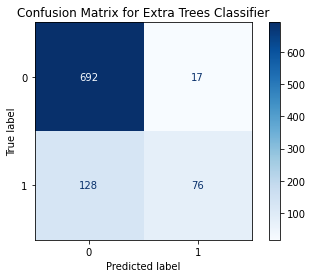

In [47]:
cm = confusion_matrix(y_test, predictions)

ConfusionMatrixDisplay(cm, display_labels=et.classes_).plot(cmap='Blues');

plt.title('Confusion Matrix for Extra Trees Classifier');

Similarly, in the confusion matrix above we can see how precision has been optimized. There are fewer cases where a listing is being categorized as popular if it is not, compared to a listing be classified as not popular but it is. This will help us to not convey false results about popularity predictions to our audience. 

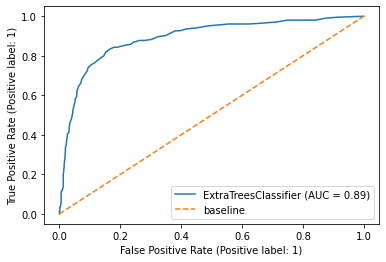

In [48]:
plot_roc_curve(et, X_test, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label = 'baseline', linestyle='--')

# add a legend
plt.legend();

The ROC curve above can show us how much overlap there is between the distribution of our classes popular and not popular. The area under the ROC curve is .89, which shows a very strong division of our classes. 

Below, I wanted to look at the featues that are the most imporant in this model. 

In [49]:
sorted(set(zip(et.feature_importances_, X.columns)), reverse=True)

[(0.10239846357153706, 'host_is_superhost'),
 (0.07129886617151307, 'days_since_first_review'),
 (0.02241002535847965, 'calculated_host_listings_count'),
 (0.018971286169065942, 'days_being_host'),
 (0.018688742243719747, 'days_since_last_review'),
 (0.017229378812937592, 'coffee_maker'),
 (0.016895640581038648, 'availability_60'),
 (0.016869511811785448, 'hair_dryer'),
 (0.015493472422040076, 'availability_30'),
 (0.014961389158482741, 'availability_90'),
 (0.014069768672232499, 'free_street_parking'),
 (0.013856947934041068, 'neighborhood_overview_neutral_sentiment'),
 (0.013827185743709048, 'availability_365'),
 (0.012111231085736543, 'neighborhood_overview_word_count'),
 (0.01175608728667026, 'maximum_nights'),
 (0.011531692597730287, 'minimum_nights'),
 (0.011472365785008732, 'tv'),
 (0.011246402628754705, 'minimum_nights_avg_ntm'),
 (0.01120651783182995, 'first_aid_kit'),
 (0.01113133696365777, 'host_about_compound_sentiment'),
 (0.011080055931611004, 'neighborhood_overview_compo

The feature importances are very similar to the output of logistic regression coefficients. It appears that the host being a super host and the days since first review are very important to being considered popular.

Below, I investigate where predictions went wrong to see if I can find any similarities. 

Create data frame to evaluate residuals for testing data. 

In [50]:
residuals = pd.DataFrame(X_test.copy())

residuals['y_test'] = pd.DataFrame(y_test)

residuals['predictions'] = predictions

residuals['residuals'] = residuals['y_test'] - residuals['predictions']

residuals.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,instant_bookable,calculated_host_listings_count,historic_site,museum,metro,music_venue,perfomring_arts_venue,college_and_university,food,nightlife_spot,outdoors_and_recreation,government_building,clothing_store,days_being_host,days_since_first_review,days_since_last_review,name_word_count,name_neutral_sentiment,name_negative_sentiment,name_positive_sentiment,name_compound_sentiment,description_word_count,description_neutral_sentiment,description_negative_sentiment,description_positive_sentiment,description_compound_sentiment,neighborhood_overview_word_count,neighborhood_overview_neutral_sentiment,neighborhood_overview_negative_sentiment,neighborhood_overview_positive_sentiment,neighborhood_overview_compound_sentiment,host_about_word_count,host_about_neutral_sentiment,host_about_negative_sentiment,host_about_positive_sentiment,host_about_compound_sentiment,wifi,smoke_alarm,essentials,heating,air_conditioning,hangers,iron,kitchen,long_term_stays_allowed,hair_dryer,carbon_monoxide_alarm,hot_water,shampoo,dedicated_workspace,dishes_and_silverware,microwave,washer,dryer,fire_extinguisher,refrigerator,coffee_maker,cooking_basics,private_entrance,bed_linens,stove,oven,free_street_parking,dishwasher,first_aid_kit,extra_pillows_and_blankets,tv,patio_or_balcony,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,"neighbourhood_cleansed_Brookland, Brentwood, Langdon","neighbourhood_cleansed_Capitol Hill, Lincoln Park","neighbourhood_cleansed_Capitol View, Marshall Heights, Benning Heights","neighbourhood_cleansed_Cathedral Heights, McLean Gardens, Glover Park","neighbourhood_cleansed_Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace","neighbourhood_cleansed_Colonial Village, Shepherd Park, North Portal Estates","neighbourhood_cleansed_Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View","neighbourhood_cleansed_Congress Heights, Bellevue, Washington Highlands","neighbourhood_cleansed_Deanwood, Burrville, Grant Park, Lincoln Heights, Fairmont Heights","neighbourhood_cleansed_Douglas, Shipley Terrace","neighbourhood_cleansed_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street","neighbourhood_cleansed_Dupont Circle, Connecticut Avenue/K Street","neighbourhood_cleansed_Eastland Gardens, Kenilworth","neighbourhood_cleansed_Edgewood, Bloomingdale, Truxton Circle, Eckington","neighbourhood_cleansed_Fairfax Village, Naylor Gardens, Hillcrest, Summit Park","neighbourhood_cleansed_Friendship Heights, American University Park, Tenleytown","neighbourhood_cleansed_Georgetown, Burleith/Hillandale","neighbourhood_cleansed_Hawthorne, Barnaby Woods, Chevy Chase",neighbourhood_cleansed_Historic Anacostia,"neighbourhood_cleansed_Howard University, Le Droit Park, Cardozo/Shaw","neighbourhood_cleansed_Ivy City, Arboretum, Trinidad, Carver Langston","neighbourhood_cleansed_Kalorama Heights, Adams Morgan, Lanier Heights","neighbourhood_cleansed_Lamont Riggs, Queens Chapel, Fort Totten, Pleasant Hill","neighbourhood_cleansed_Mayfair, Hillbrook, Mahaning Heights","neighbourhood_cleansed_Near Southeast, Navy Yard","neighbourhood_cleansed_North Cleveland Park, Forest Hills, Van Ness","neighbourhood_cleansed_North Michigan Park, Michigan Park, University Heights","neighbourhood_cleansed_River Terrace, Benning, Greenway, Dupont Park","neighbourhood_cleansed_Shaw, Logan Circle","neighbourhood_cleansed_Sheridan, Barry Farm, Buena Vista","neighbourhood_cleansed_Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point","neighbourhood_cleansed_Spring Valley, Palisades, Wesley Heights, Foxhall Crescent, Foxhall Village, Geor

Observe listings that were in fact popular but predicted as not.

In [51]:
residuals[residuals['residuals']==1].head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,instant_bookable,calculated_host_listings_count,historic_site,museum,metro,music_venue,perfomring_arts_venue,college_and_university,food,nightlife_spot,outdoors_and_recreation,government_building,clothing_store,days_being_host,days_since_first_review,days_since_last_review,name_word_count,name_neutral_sentiment,name_negative_sentiment,name_positive_sentiment,name_compound_sentiment,description_word_count,description_neutral_sentiment,description_negative_sentiment,description_positive_sentiment,description_compound_sentiment,neighborhood_overview_word_count,neighborhood_overview_neutral_sentiment,neighborhood_overview_negative_sentiment,neighborhood_overview_positive_sentiment,neighborhood_overview_compound_sentiment,host_about_word_count,host_about_neutral_sentiment,host_about_negative_sentiment,host_about_positive_sentiment,host_about_compound_sentiment,wifi,smoke_alarm,essentials,heating,air_conditioning,hangers,iron,kitchen,long_term_stays_allowed,hair_dryer,carbon_monoxide_alarm,hot_water,shampoo,dedicated_workspace,dishes_and_silverware,microwave,washer,dryer,fire_extinguisher,refrigerator,coffee_maker,cooking_basics,private_entrance,bed_linens,stove,oven,free_street_parking,dishwasher,first_aid_kit,extra_pillows_and_blankets,tv,patio_or_balcony,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,"neighbourhood_cleansed_Brookland, Brentwood, Langdon","neighbourhood_cleansed_Capitol Hill, Lincoln Park","neighbourhood_cleansed_Capitol View, Marshall Heights, Benning Heights","neighbourhood_cleansed_Cathedral Heights, McLean Gardens, Glover Park","neighbourhood_cleansed_Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace","neighbourhood_cleansed_Colonial Village, Shepherd Park, North Portal Estates","neighbourhood_cleansed_Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View","neighbourhood_cleansed_Congress Heights, Bellevue, Washington Highlands","neighbourhood_cleansed_Deanwood, Burrville, Grant Park, Lincoln Heights, Fairmont Heights","neighbourhood_cleansed_Douglas, Shipley Terrace","neighbourhood_cleansed_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street","neighbourhood_cleansed_Dupont Circle, Connecticut Avenue/K Street","neighbourhood_cleansed_Eastland Gardens, Kenilworth","neighbourhood_cleansed_Edgewood, Bloomingdale, Truxton Circle, Eckington","neighbourhood_cleansed_Fairfax Village, Naylor Gardens, Hillcrest, Summit Park","neighbourhood_cleansed_Friendship Heights, American University Park, Tenleytown","neighbourhood_cleansed_Georgetown, Burleith/Hillandale","neighbourhood_cleansed_Hawthorne, Barnaby Woods, Chevy Chase",neighbourhood_cleansed_Historic Anacostia,"neighbourhood_cleansed_Howard University, Le Droit Park, Cardozo/Shaw","neighbourhood_cleansed_Ivy City, Arboretum, Trinidad, Carver Langston","neighbourhood_cleansed_Kalorama Heights, Adams Morgan, Lanier Heights","neighbourhood_cleansed_Lamont Riggs, Queens Chapel, Fort Totten, Pleasant Hill","neighbourhood_cleansed_Mayfair, Hillbrook, Mahaning Heights","neighbourhood_cleansed_Near Southeast, Navy Yard","neighbourhood_cleansed_North Cleveland Park, Forest Hills, Van Ness","neighbourhood_cleansed_North Michigan Park, Michigan Park, University Heights","neighbourhood_cleansed_River Terrace, Benning, Greenway, Dupont Park","neighbourhood_cleansed_Shaw, Logan Circle","neighbourhood_cleansed_Sheridan, Barry Farm, Buena Vista","neighbourhood_cleansed_Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point","neighbourhood_cleansed_Spring Valley, Palisades, Wesley Heights, Foxhall Crescent, Foxhall Village, Geor

Observe listings that were predicted as popular but are not.

In [52]:
residuals[residuals['residuals']==-1].head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,instant_bookable,calculated_host_listings_count,historic_site,museum,metro,music_venue,perfomring_arts_venue,college_and_university,food,nightlife_spot,outdoors_and_recreation,government_building,clothing_store,days_being_host,days_since_first_review,days_since_last_review,name_word_count,name_neutral_sentiment,name_negative_sentiment,name_positive_sentiment,name_compound_sentiment,description_word_count,description_neutral_sentiment,description_negative_sentiment,description_positive_sentiment,description_compound_sentiment,neighborhood_overview_word_count,neighborhood_overview_neutral_sentiment,neighborhood_overview_negative_sentiment,neighborhood_overview_positive_sentiment,neighborhood_overview_compound_sentiment,host_about_word_count,host_about_neutral_sentiment,host_about_negative_sentiment,host_about_positive_sentiment,host_about_compound_sentiment,wifi,smoke_alarm,essentials,heating,air_conditioning,hangers,iron,kitchen,long_term_stays_allowed,hair_dryer,carbon_monoxide_alarm,hot_water,shampoo,dedicated_workspace,dishes_and_silverware,microwave,washer,dryer,fire_extinguisher,refrigerator,coffee_maker,cooking_basics,private_entrance,bed_linens,stove,oven,free_street_parking,dishwasher,first_aid_kit,extra_pillows_and_blankets,tv,patio_or_balcony,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,"neighbourhood_cleansed_Brookland, Brentwood, Langdon","neighbourhood_cleansed_Capitol Hill, Lincoln Park","neighbourhood_cleansed_Capitol View, Marshall Heights, Benning Heights","neighbourhood_cleansed_Cathedral Heights, McLean Gardens, Glover Park","neighbourhood_cleansed_Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace","neighbourhood_cleansed_Colonial Village, Shepherd Park, North Portal Estates","neighbourhood_cleansed_Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View","neighbourhood_cleansed_Congress Heights, Bellevue, Washington Highlands","neighbourhood_cleansed_Deanwood, Burrville, Grant Park, Lincoln Heights, Fairmont Heights","neighbourhood_cleansed_Douglas, Shipley Terrace","neighbourhood_cleansed_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street","neighbourhood_cleansed_Dupont Circle, Connecticut Avenue/K Street","neighbourhood_cleansed_Eastland Gardens, Kenilworth","neighbourhood_cleansed_Edgewood, Bloomingdale, Truxton Circle, Eckington","neighbourhood_cleansed_Fairfax Village, Naylor Gardens, Hillcrest, Summit Park","neighbourhood_cleansed_Friendship Heights, American University Park, Tenleytown","neighbourhood_cleansed_Georgetown, Burleith/Hillandale","neighbourhood_cleansed_Hawthorne, Barnaby Woods, Chevy Chase",neighbourhood_cleansed_Historic Anacostia,"neighbourhood_cleansed_Howard University, Le Droit Park, Cardozo/Shaw","neighbourhood_cleansed_Ivy City, Arboretum, Trinidad, Carver Langston","neighbourhood_cleansed_Kalorama Heights, Adams Morgan, Lanier Heights","neighbourhood_cleansed_Lamont Riggs, Queens Chapel, Fort Totten, Pleasant Hill","neighbourhood_cleansed_Mayfair, Hillbrook, Mahaning Heights","neighbourhood_cleansed_Near Southeast, Navy Yard","neighbourhood_cleansed_North Cleveland Park, Forest Hills, Van Ness","neighbourhood_cleansed_North Michigan Park, Michigan Park, University Heights","neighbourhood_cleansed_River Terrace, Benning, Greenway, Dupont Park","neighbourhood_cleansed_Shaw, Logan Circle","neighbourhood_cleansed_Sheridan, Barry Farm, Buena Vista","neighbourhood_cleansed_Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point","neighbourhood_cleansed_Spring Valley, Palisades, Wesley Heights, Foxhall Crescent, Foxhall Village, Geor

The biggest differences in where predictions are going wrong that I see are with some of the most important variables to the model. For example, if the host is a super host, has many days since the first review, and has a high response rate the model will categorize this listing as popular. Similarly, if the listing is in fact popular but it is not a super host for example, the model will not categorize this as a popular listing. 

Lastly, I will pickle the model to use in production below.

In [53]:
with open('../models/et.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(et, pickle_out)

Below, I will display the logistic regression model that I will turn to for interpretation of coefficients and reccomendations. Random states have been added for reproducable model resutls.  

In [54]:
X = df.drop(columns=['popular'])
y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=100 )

In [55]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)

X_test_sc = ss.transform(X_test)

In [56]:
logreg = LogisticRegression(random_state=100)

logreg.fit(X_train_sc, y_train)

predictions = logreg.predict(X_test_sc)

print(f'training accuracy score: {logreg.score(X_train_sc, y_train)}')

print(f'testing accuracy score: {logreg.score(X_test_sc, y_test)}')

print(f'testing f1 score: {f1_score(y_test, predictions)}')

print(f'testing precision score: {precision_score(y_test, predictions)}')

print(f'testing recall score: {recall_score(y_test, predictions)}')

training accuracy score: 0.8543263964950711
testing accuracy score: 0.8357064622124863
testing f1 score: 0.5689655172413792
testing precision score: 0.6875
testing recall score: 0.4852941176470588


The metrics above show how logistic regession is performing on our data. The accuracy score on testing data is 84% and the precision score is 69%, which is not as great as the extra trees classifier. This shows why another model is best for prediciton, but that this model is still useful to use for interpreting coefficients. 

In [57]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       709
           1       0.69      0.49      0.57       204

    accuracy                           0.84       913
   macro avg       0.78      0.71      0.73       913
weighted avg       0.82      0.84      0.82       913



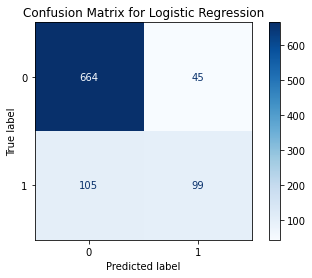

In [58]:
cm = confusion_matrix(y_test, predictions)

ConfusionMatrixDisplay(cm, display_labels=logreg.classes_).plot(cmap='Blues');

plt.title('Confusion Matrix for Logistic Regression');

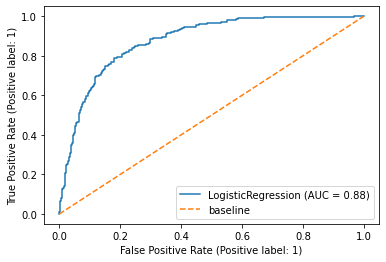

In [59]:
plot_roc_curve(logreg, X_test_sc, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label = 'baseline', linestyle='--')

# add a legend
plt.legend();

The figures above show that logistic regression still does a good job with preicision in the confusion matrix and distributing between different classes in the ROC curve. 

In [60]:
sorted(set(zip(np.exp(logreg.coef_[0]), X.columns ) ), reverse=True)

[(3.023979739992702, 'days_since_first_review'),
 (2.252279025166598, 'host_is_superhost'),
 (1.5239097484616326, 'accommodates'),
 (1.452820854517766, 'description_neutral_sentiment'),
 (1.4109007516353662, 'dishes_and_silverware'),
 (1.3375123577425647, 'host_response_time_unknown'),
 (1.2524784761223506, 'host_acceptance_rate'),
 (1.2299120083037685, 'minimum_nights'),
 (1.2181618977570867, 'smoke_alarm'),
 (1.200869951892351, 'hair_dryer'),
 (1.1897052279219804, 'carbon_monoxide_alarm'),
 (1.1833871167305794, 'host_about_positive_sentiment'),
 (1.1672572894095743, 'description_positive_sentiment'),
 (1.1648823882154373, 'neighborhood_overview_negative_sentiment'),
 (1.1603318337721686, 'iron'),
 (1.148824435904071, 'hangers'),
 (1.1473234875136338, 'first_aid_kit'),
 (1.1445024711182876, 'neighborhood_overview_positive_sentiment'),
 (1.135070247010417, 'stove'),
 (1.130962127205443, 'host_has_profile_pic'),
 (1.1223850438860763, 'description_compound_sentiment'),
 (1.12119682587437

These articles helped me to understand logistic regression coefficient interpretation which I will be talking more about below.

https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1

https://www.displayr.com/how-to-interpret-logistic-regression-coefficients/

The coefficients above have been untransformed from their logged version but still in standard scaler units. Odds less than one here are our negative coefficients.

Interpreting these coefficients for recommendations to hosts are as followed: 

Holding all else constant, as days since first review (scaled units) increases by 1, the odds that the listing is popular is 3.02 times as large as the odds that the listing is not popular. 

If this host is a superhost, the odds that the listing is popular is 2.25 time more than the odds that the listing is not popular.  

This same interpretation can be used for all the other logistic regression coefficients shown in the print out above. 

I will take these interpretations for each coefficient, and let the host know what features they are missing and could add to their listing to increase the likelihood it will be considered popular. 

Below shows how I will get the probability prediction in my production model for a listing entry. I will be using the standard 50/50 threshhold for my predictions. I will get the likelihood of whether or not the listing will be considered popular. 

In [61]:
logreg.predict_proba(X_test_sc)[:,1]

array([4.88684620e-03, 3.65760865e-03, 2.24668246e-01, 3.21174848e-02,
       4.00343269e-02, 1.16920726e-02, 3.88846760e-01, 3.66801799e-01,
       9.37742667e-01, 2.59332549e-02, 6.90429390e-01, 5.67810845e-01,
       2.12216853e-02, 6.02866560e-01, 5.19306950e-01, 6.46382153e-02,
       5.32721320e-01, 7.34518304e-01, 4.63156512e-01, 3.17382415e-01,
       6.05974376e-01, 2.04499370e-01, 1.68724340e-04, 7.87637962e-01,
       7.06162024e-02, 1.51224611e-05, 4.02957969e-02, 3.19073375e-01,
       1.22621842e-02, 6.40679222e-02, 5.35885167e-01, 1.16856782e-01,
       7.90758686e-02, 1.46117381e-01, 1.84346885e-02, 7.31522382e-01,
       1.07353440e-02, 4.72241060e-01, 1.00843244e-13, 7.01350634e-02,
       8.78058195e-01, 2.00839637e-01, 6.59819776e-04, 1.24574139e-01,
       1.91413445e-01, 2.14109438e-02, 1.81715873e-01, 4.20542325e-02,
       2.64686747e-01, 5.98818586e-02, 1.31360429e-02, 1.64013097e-03,
       1.37489125e-02, 3.91158627e-03, 8.99034609e-01, 2.44724412e-02,
      

Pickle model to use in production.

In [62]:
with open('../models/lr.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(logreg, pickle_out)

Pickle neighborhood venue information for production model.

In [63]:
neighborhood_venues = pd.read_csv('../data/neighborhood_venues.csv').drop(columns=['Unnamed: 0','latitude', 'longitude'])

In [64]:
neighborhood_venues.set_index('neighbourhood_cleansed', inplace=True)

In [65]:
neighborhood_venues = dict(neighborhood_venues)

In [66]:
with open('../models/neighborhood_venues.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(neighborhood_venues, pickle_out)